In [38]:
import numpy as np
import os, h5py

from utils import plot_data, return_best_chi2dof, plot_ref_data, BuildSample_DY, normalize, candidate_sigma
from scipy.special import logsumexp
from scipy.stats import norm

from matplotlib import pyplot as plt

## normalization and kernel width

In [2]:
cut_mll = 60
cut_pt = 20
cut_eta = 2.4

In [23]:
# feature order ['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2']s
all_ref = BuildSample_DY(N_Events=100000000, INPUT_PATH='/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', rng=np.random.default_rng(seed=1234))

mask_idx_1 = np.where((all_ref[:, 4] <= cut_pt) | (all_ref[:, 5] <= cut_pt) | (np.abs(all_ref[:, 1]) > cut_eta) | (np.abs(all_ref[:, 2]) > cut_eta) | (all_ref[:, 3] <= cut_mll))[0]
masked_all_ref = np.delete(all_ref, mask_idx_1, axis=0)

mean_R = np.mean(masked_all_ref, axis=0)
std_R  = np.std(masked_all_ref, axis=0)

print(mean_R)
print(std_R)

DiLepton_SM


(3735456, 6)
[3.05212537e+00 4.59876795e-04 3.66978211e-04 9.11198636e+01
 4.67488118e+01 3.60544255e+01]
[ 0.52342366  1.24487457  1.25051629 12.79724998 15.86122412  8.95046637]


In [29]:
# feature order ['delta_phi', 'eta1', 'eta2', 'mll', 'pt1', 'pt2']
ref_sample = BuildSample_DY(N_Events=20000, INPUT_PATH='/data/marcol/HEPDATA/DILEPTON/DiLepton_SM/', rng=np.random.default_rng(seed=0))
mask_idx_2 = np.where((ref_sample[:, 4] <= cut_pt) | (ref_sample[:, 5] <= cut_pt) | (np.abs(ref_sample[:, 1]) > cut_eta) | (np.abs(ref_sample[:, 2]) > cut_eta) | (ref_sample[:, 3] <= cut_mll))[0]
masked_ref_sample = np.delete(ref_sample, mask_idx_2, axis=0)

norm_masked_ref_sample = normalize(masked_ref_sample[:,[0,1,2,4,5]],np.delete(mean_R, 3),np.delete(std_R, 3))

for perc in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"{perc}%: {candidate_sigma(norm_masked_ref_sample, perc=perc)}")

DiLepton_SM
(20000, 6)
1: 0.316
5: 0.571
10: 0.766
25: 1.19
50: 1.787
75: 2.489
90: 3.175
95: 3.568
99: 4.226


## nplm-fuse

In [2]:
ref_folder = "./output_nest_5d/Ntoys1000_NR100000_NB20000_cut60_null"
data_folder = "/Users/marco/GitHub/mletizia-multiple-testing-nplm/output_nest_5d/Ntoys300_NR100000_NB20000_NS40_Z200_cut60"

In [3]:
#[0.31,0.76,1.77,3.15,4.21] 1,10,50,90,99 percentiles
ref = np.load(ref_folder+"/t_array.npy")
data = np.load(data_folder+"/t_array.npy")

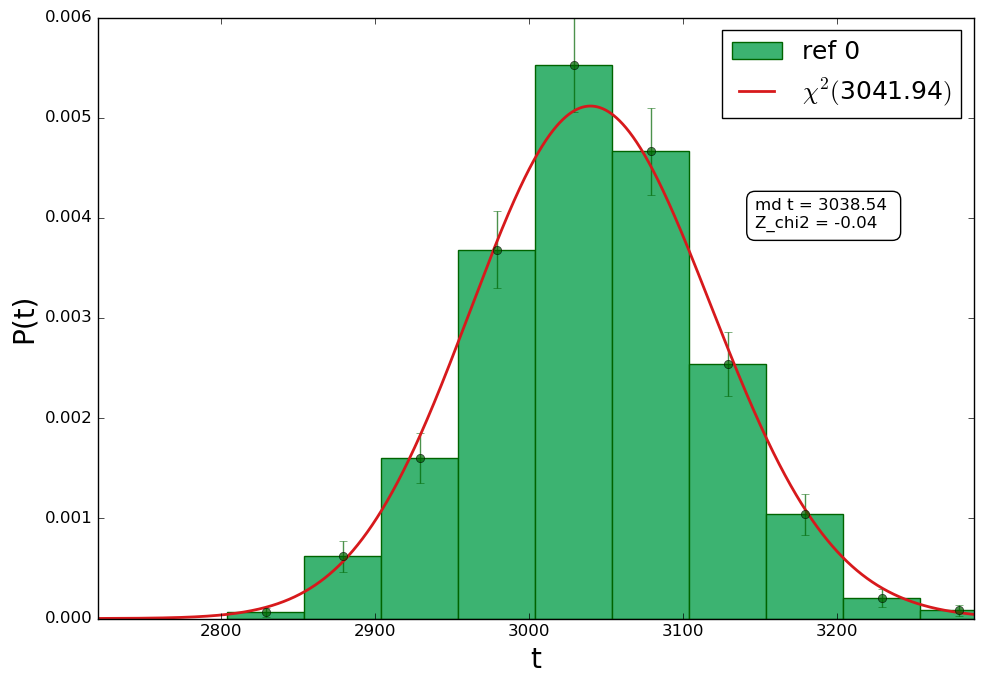

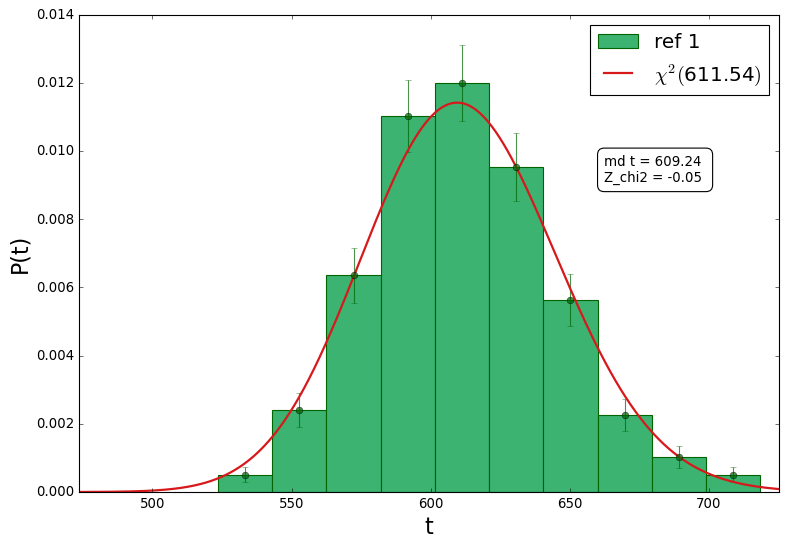

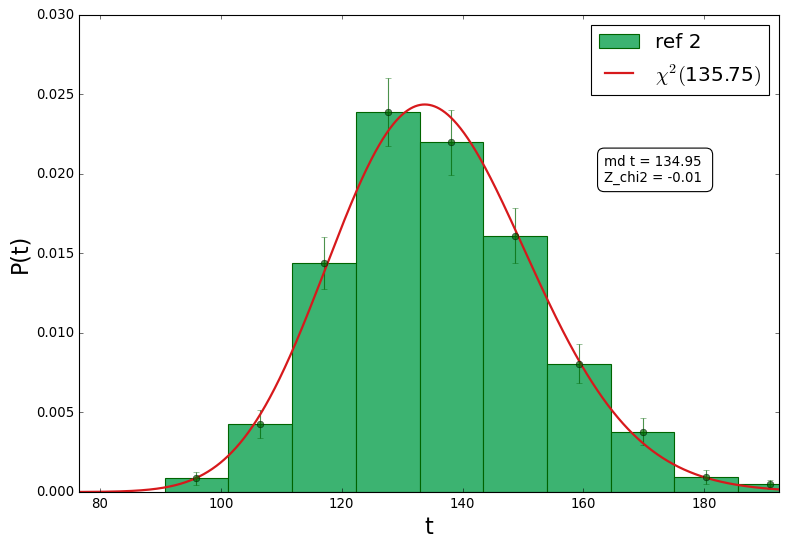

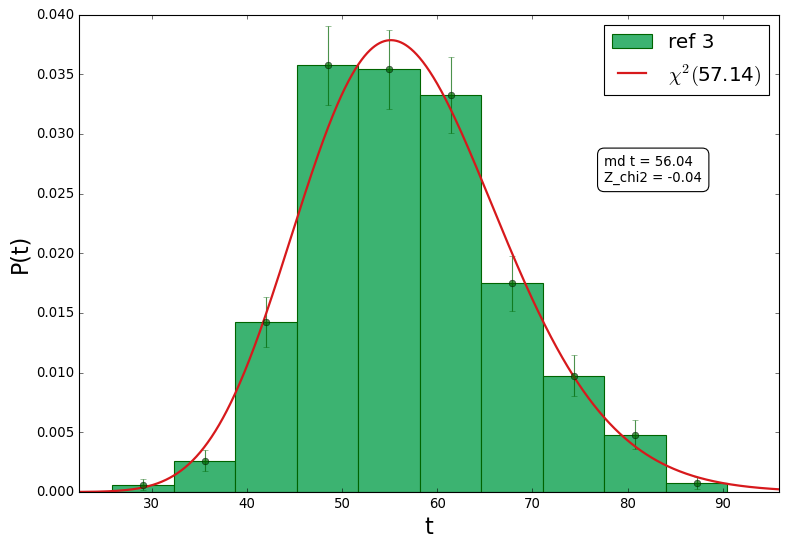

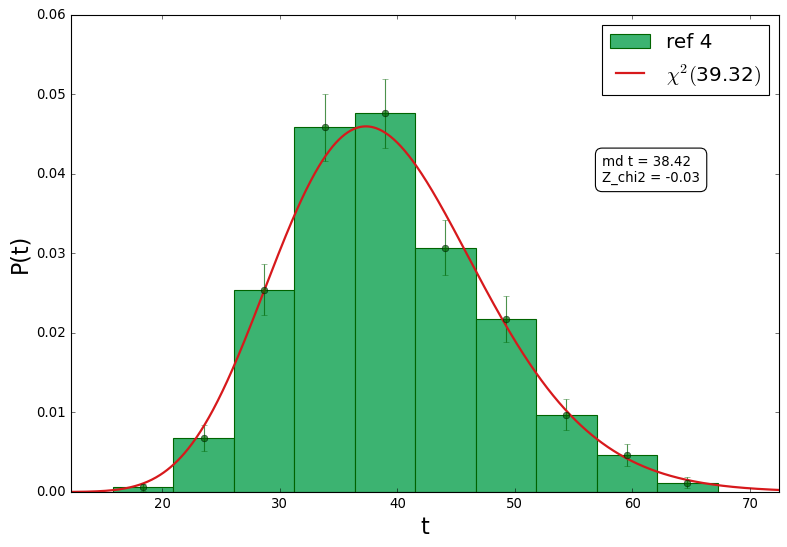

In [4]:
# check null distributions and chi2
for i in np.arange(ref.shape[1]):
    plot_data(ref[:,i], label=f'ref {i}', dof=round(return_best_chi2dof(ref[:,i])[0],2))

In [5]:
def emp_p_value(ref,data,right=True):
    #for idx,el in enumerate(t):
    #    p[idx] = np.mean(ref>=t)
    if right : p = np.array([np.mean(ref>=t) for t in data])
    else : p = np.array([np.mean(ref<=t) for t in data])
    p[p==0] = 1/len(ref)
    return p

def p_to_z(pvals):
    return norm.ppf(1 - pvals)

def Zscore(ref,data):
    return p_to_z(emp_p_value(ref,data))

def power(t_ref,t_data, alpha=np.array([0.309,0.159,0.06681,0.0228,0.00620]), right=True):
    # alpha values approx corresponding to Z=.5,1,2,2.5
    if right: quantiles = np.quantile(t_ref,1-alpha)
    else: quantiles = np.quantile(t_ref,alpha)
    return p_to_z(alpha), emp_p_value(t_data,quantiles, right=right)
    

def fusion(x,T):
    return T * logsumexp(1/T*x, axis=1, b=1/x.shape[1])

def fused_t(ref,data,T):
    fused_ref = fusion(ref,T)
    fused_data = fusion(data,T)

    return emp_p_value(fused_ref,fused_data)

def bootstrap_pn(pn,seed=None):
    rnd = np.random.default_rng(seed=seed)
    return rnd.choice(pn,size=len(pn))

def bootstrap_pval(pn,t,seed=None):

    p = np.mean(bootstrap_pn(pn,seed=seed)<=t)

    return p if p > 0 else 1/(len(pn)+1)

    return 

def min_p(ref,data):
    # ref: nxd numpy array
    # data: mxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    p_ref[p_ref == 0] = 1/ref.shape[0]
    p_data[p_data == 0] = 1/ref.shape[0]


    return -np.log(np.min(p_ref,axis=1)), -np.log(np.min(p_data,axis=1))

def fused_p(ref,data,T=1):
    # ref: n_refxd numpy array
    # data: n_dataxd numpy array
    p_ref = np.zeros_like(ref)
    p_data = np.zeros_like(data)

    # empirical p-values for reference toys with a bootstrap approach
    for idx, col in enumerate(np.transpose(ref)):
        p_ref[:,idx] = np.transpose([bootstrap_pval(np.delete(col,idx),el) for el in col])

    # empirical p-values of data
    for idx, col in enumerate(np.transpose(data)):
        p=emp_p_value(np.transpose(ref)[idx],col)
        p_data[:,idx] = np.transpose(p)

    p_ref[p_ref == 0] = 1/ref.shape[0]
    p_data[p_data == 0] = 1/ref.shape[0]

    #return np.min(p_ref,axis=1), np.min(p_data,axis=1)
    return -np.log(-T * logsumexp(-1/T*p_ref, axis=1, b=1/p_ref.shape[1])), -np.log(-T * logsumexp(-1/T*p_data, axis=1, b=1/p_data.shape[1]))


In [6]:
for i in range(ref.shape[1]):
    print(np.median(Zscore(ref[:,i],data[:,i])))

0.3651495764595648
0.9965170769127061
0.9058933603844871
0.9287877308601915
0.8116381514746511


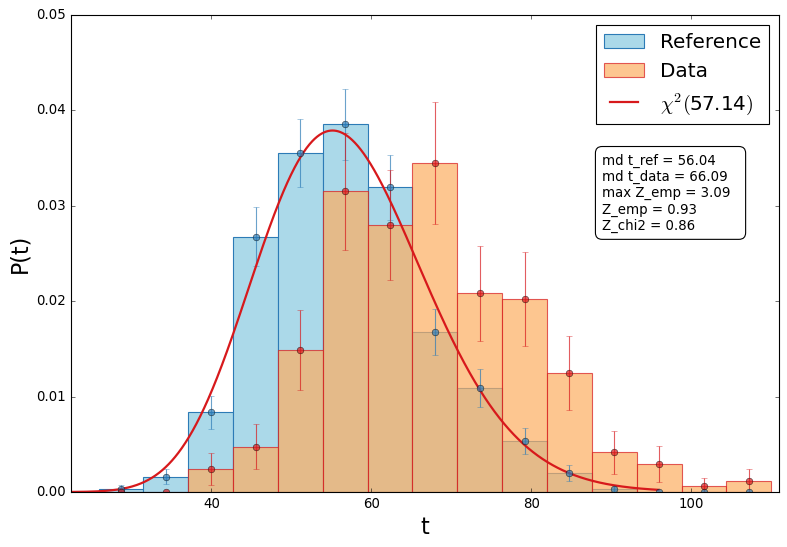

In [7]:
plot_ref_data(ref[:,-2],data[:,-2],bins=15,dof=round(return_best_chi2dof(ref[:10000,-2])[0],2))

In [8]:
for T in [0.001, 1, 10, 1000, 1e5, 1e10]:
    print(np.median(p_to_z((fused_t(ref,data,T)))))

0.3651495764595648
0.3651495764595648
0.3651495764595648
0.38802166621797707
0.8309585277650613
0.841626602579728


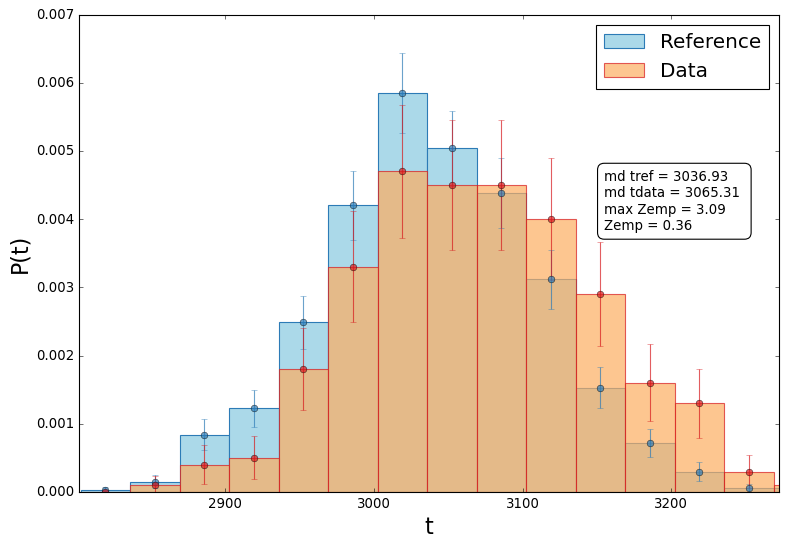

In [9]:
plot_ref_data(fusion(ref,1),fusion(data,1),bins=15)

In [10]:
pmin_ref, pmin_data =  min_p(ref,data)

In [11]:
np.abs(np.median(Zscore(pmin_ref,pmin_data)))

0.8523857979575749

In [28]:
pvals_min_p_ref = []
for idx, el in enumerate(np.transpose(pmin_ref)):
        pvals_min_p_ref.append(bootstrap_pval(np.delete(pmin_ref,idx),el))
#pvals_ref_min = [bootstrap_pval(np.delete(col,idx),el) for el in col]
        
pvals_min_p_data = emp_p_value(pmin_ref,pmin_data)

In [29]:
np.max(pvals_min_p_ref)

1.0

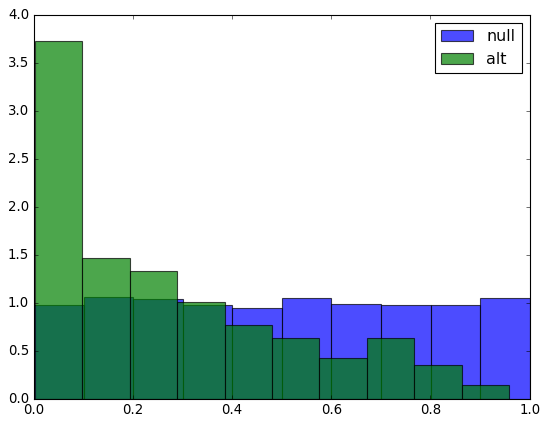

In [30]:
plt.hist(pvals_min_p_ref,bins=10,density=True, alpha=0.7,  label='null')
plt.hist(pvals_min_p_data,bins=10,density=True, alpha=0.7, label='alt')
plt.legend(loc=0)
plt.show()

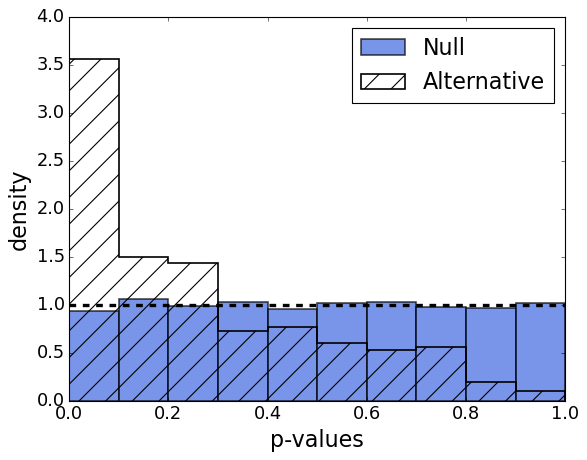

In [27]:
bins=np.linspace(0,1,11)
plt.hist(pvals_min_p_ref,bins=bins, density=True, color='royalblue', alpha=0.7, lw=1.5,  label='Null')
plt.hist(pvals_min_p_data,bins=bins, density=True, histtype='step', edgecolor='k', hatch='/', lw=1.5, fill=False, label='Alternative')
plt.hlines(1, 0, 1, colors='k', linestyles='--', lw=3)
plt.xlabel("p-values", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim((0.6,1.4))
plt.legend(loc=0, fontsize=20)
plt.show()

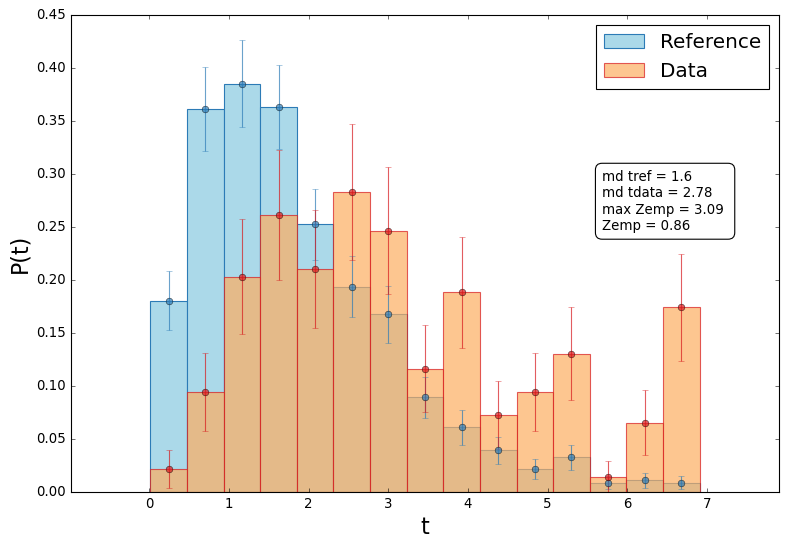

In [14]:
plot_ref_data(pmin_ref,pmin_data,bins=15)

In [31]:
for T in [1e-3, 0.1, 1, 100, 1000]:
    fused_p_ref, fused_p_data = fused_p(ref,data,T)
    print(np.abs(np.median(Zscore(fused_p_ref,fused_p_data))))

0.8632500515934207
1.0938973526034372
1.180000540347729
1.1076800921478
1.1455050613926967


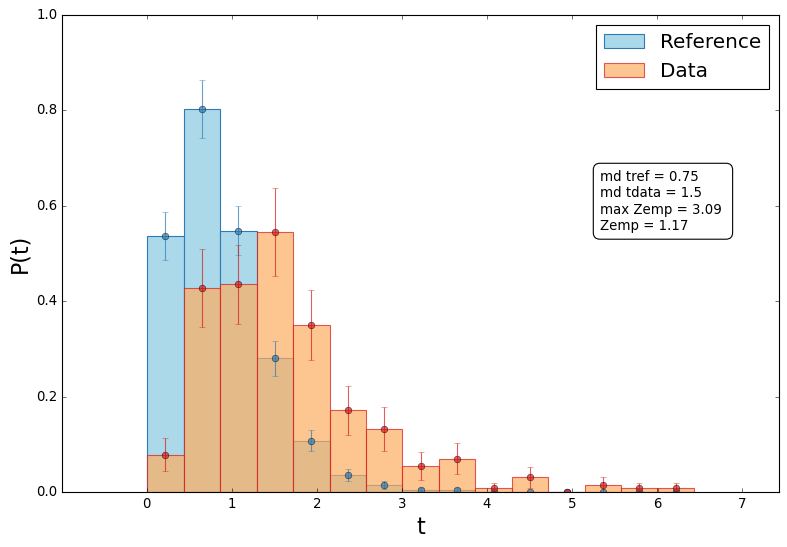

In [37]:
fused_p1_ref, fused_p1_data = fused_p(ref,data,T=1)
plot_ref_data(fused_p1_ref,fused_p1_data,bins=15)

In [32]:
pvals_fused_p_ref = []
for idx, el in enumerate(np.transpose(fused_p_ref)):
        pvals_fused_p_ref.append(bootstrap_pval(np.delete(fused_p_ref,idx),el))
pvals_fused_p_ref = np.array(pvals_fused_p_ref)
pvals_fused_p_ref[pvals_fused_p_ref==0.]=0.001
pvals_fused_p_ref = -np.log(pvals_fused_p_ref)

In [33]:
np.count_nonzero(pvals_fused_p_ref)

998

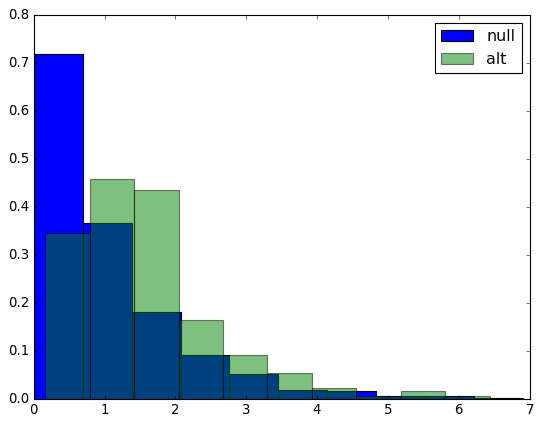

In [36]:
plt.hist(pvals_fused_p_ref,bins=10,density=True, label='null')
plt.hist(fused_p_data,bins=10,density=True, alpha=0.5, label='alt')
plt.legend(loc=0)
plt.show()

In [22]:
fused_p_ref, fused_p_data = fused_p(ref,data)
print(
    power(fusion(ref,1),fusion(data,1))[1],
    power(pmin_ref,pmin_data)[1],
    power(fused_p_ref,fused_p_data)[1],
    )

[0.45333333 0.27       0.15       0.07333333 0.02      ] [0.66666667 0.43666667 0.27       0.17666667 0.08      ] [0.69666667 0.56       0.35333333 0.19666667 0.11666667]


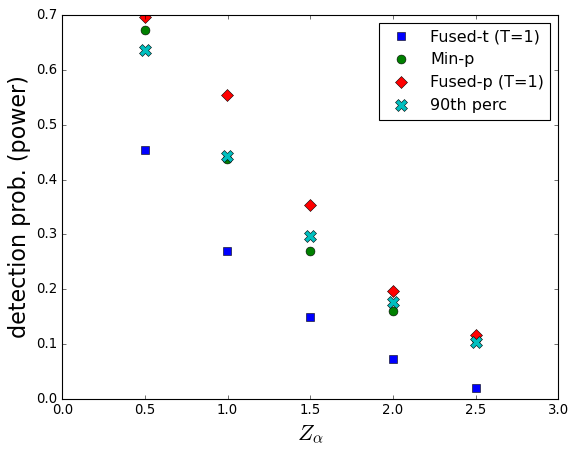

In [20]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

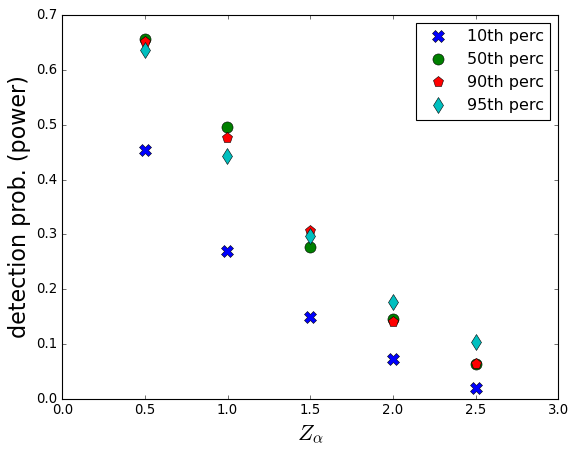

In [21]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,0],data[:,0])[1],label='10th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,1],data[:,1])[1],label='50th perc',linestyle='None',marker='o',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,2],data[:,2])[1],label='90th perc',linestyle='None',marker='p',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,3],data[:,3])[1],label='95th perc',linestyle='None',marker='d',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

## nplm-avg

In [22]:
ref_avg = np.load(ref_folder+"/t_avg_array.npy")
data_avg = np.load(data_folder+"/t_avg_array.npy")

ref_avg_exp = np.load(ref_folder+"/t_avg_exp_array.npy")
data_avg_exp = np.load(data_folder+"/t_avg_exp_array.npy")

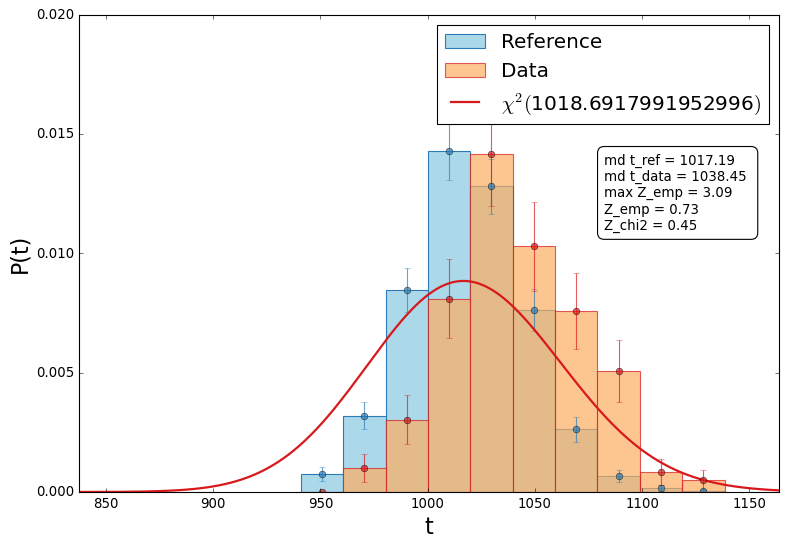

In [23]:
plot_ref_data(ref_avg,data_avg,dof=return_best_chi2dof(ref_avg)[0])

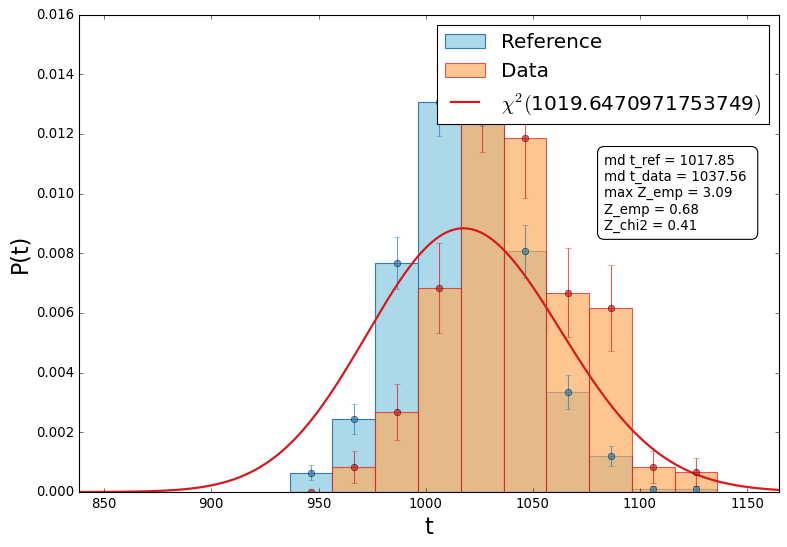

In [24]:
plot_ref_data(ref_avg_exp,data_avg_exp,dof=return_best_chi2dof(ref_avg_exp[:50000])[0])

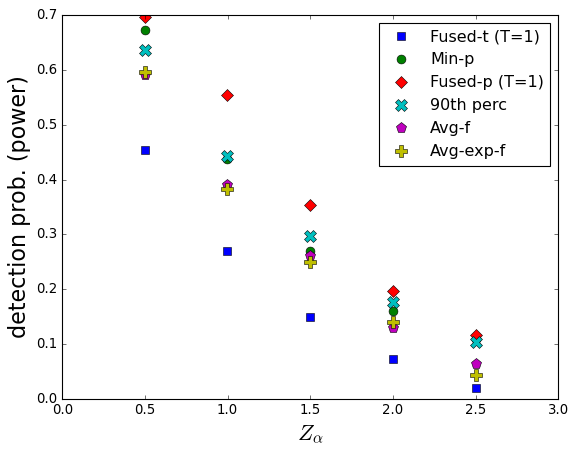

In [25]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fusion(ref,1),fusion(data,1))[1],label='Fused-t (T=1)',linestyle='None',marker='s',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(fused_p_ref,fused_p_data)[1],label='Fused-p (T=1)',linestyle='None',marker='D',ms=8)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg,data_avg)[1],label='Avg-f',linestyle='None',marker='p',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref_avg_exp,data_avg_exp)[1],label='Avg-exp-f',linestyle='None',marker='P',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()

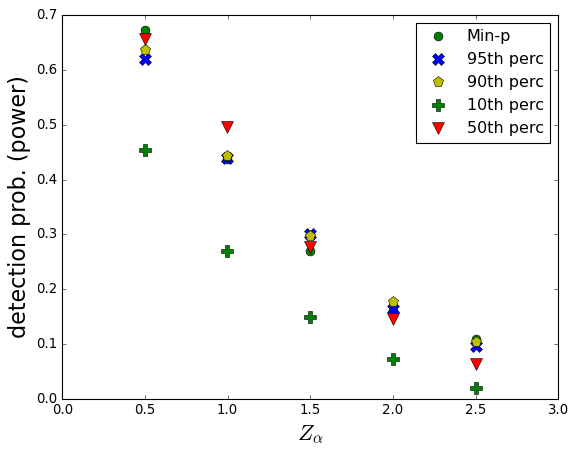

In [26]:
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(pmin_ref,pmin_data)[1],label='Min-p',linestyle='None',marker='o',ms=8, color='g')
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-1],data[:,-1])[1],label='95th perc',linestyle='None',marker='X',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,-2],data[:,-2])[1],label='90th perc',linestyle='None',marker='p',ms=10,c='y')
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,0],data[:,0])[1],label='10th perc',linestyle='None',marker='P',ms=10)
plt.plot(power(fusion(ref,1),fusion(data,1))[0],power(ref[:,1],data[:,1])[1],label='50th perc',linestyle='None',marker='v',ms=10)
plt.legend(numpoints=1)
plt.xlabel(r'$Z_\alpha$', fontsize=20)
plt.ylabel('detection prob. (power)', fontsize=20)
plt.show()